# Check training result

In [54]:
TEST_CODE = "1561003485.396884"
CHOSEN_EPOCH = 35

MODEL_PATH = "../log/{}/models/epoch_{}".format(TEST_CODE, CHOSEN_EPOCH)
LOG_PATH = "../log/{}/log.txt".format(TEST_CODE)

In [55]:
log = open(LOG_PATH).readlines()

Parameter

In [56]:
log[0]

"Namespace(base_lr=0.0005, batch_size=500, decay_epoch_step=25, display_step=1, grad_clip=False, hidden_neuron=100, lambda_value=1, optimizer_method='Adam', random_seed=1000, save_step=5, train_epoch=100)\n"

In [57]:
train_log = log[1::2]
test_log = log[2::2]

In [58]:
train_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in train_log][:-1]
test_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in test_log]
test_RMSE = [float(line.split('\t')[2].replace("RMSE = ","")) for line in test_log]

In [59]:
n_train = int(138493 * 0.9)
n_test = int(138493 * 0.1)

train_cost = [x/n_train for x in train_cost]
test_cost = [x/n_test for x in test_cost]

## Plot

In [60]:
import matplotlib.pyplot as plt

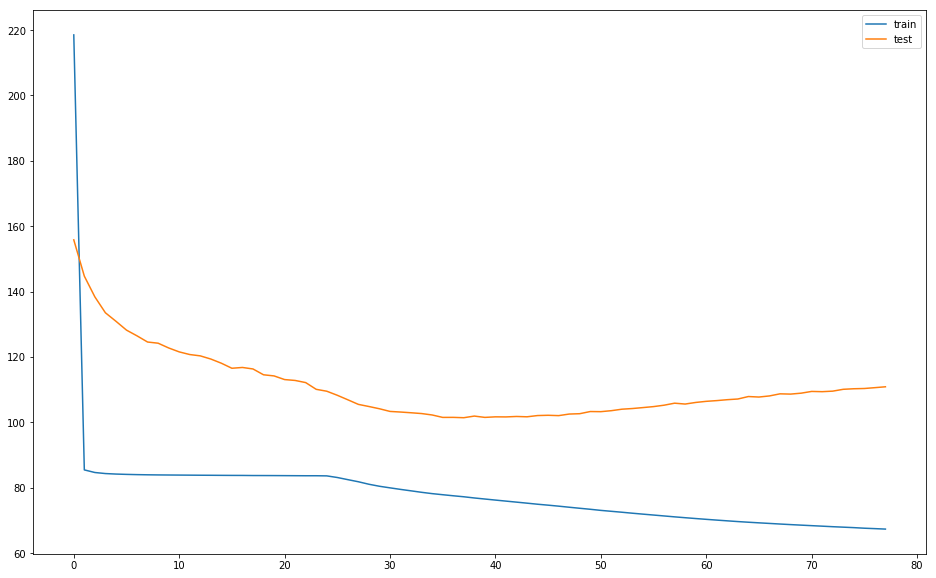

In [61]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(train_cost)), train_cost, label="train")
plt.plot(range(0, len(test_cost)), test_cost, label="test")
plt.legend()

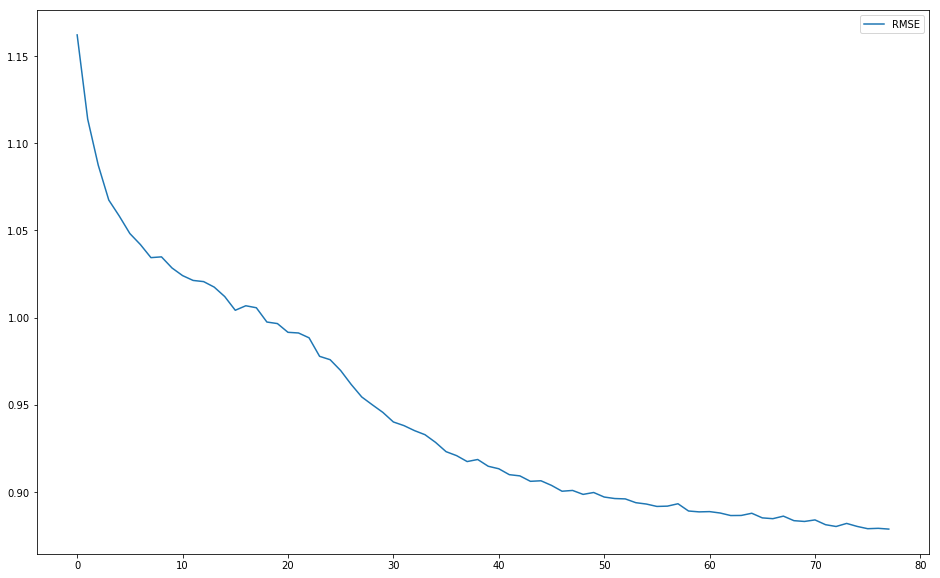

In [63]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(test_RMSE)), test_RMSE, label="RMSE")
plt.legend()

# Model

In [10]:
class Args:
    
    def __init__(self):
        self.hidden_neuron = 100
        self.lambda_value = 1.0
        
        self.train_epoch = 100
        self.batch_size = 200
        
        self.optimizer_method = 'Adam' # 'Adam','RMSProp'
        self.grad_clip = False
        self.base_lr = 0.003
        self.decay_epoch_step = 50
        
        self.random_seed = 1000
        self.display_step = 1
        self.save_step = 5
        
    def __str__(self):
        return "hidden_neuron : {}\nlambda_value : {}\ntrain_epoch : {}\nbatch_size : {}\noptimizer_method : {}\ngrad_clip : {}\nbase_lr : {}\ndecay_epoch_step : {}\nrandom_seed : {}\ndisplay_step : {}\n".format(
            self.hidden_neuron,
            self.lambda_value,
            self.train_epoch,
            self.batch_size,
            self.optimizer_method,
            self.grad_clip,
            self.base_lr,
            self.decay_epoch_step,
            self.random_seed,
            self.display_step,
            self.save_step)

args = Args()

In [11]:
import pickle
import os

class Logger:

    def set_default_filename(self, filename):
        self.default_filename = filename

    def create_session_folder(self, path):
        try:  
            os.makedirs(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
        else:  
            print ("     ===> Successfully created the directory %s \n" % path)

    def log(self, text):
        with open(self.default_filename, 'a') as f:
            f.writelines(text)
            f.write("\n")

    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))
    
    

In [12]:
import tensorflow as tf
import time
import numpy as np
import os
import math
from datetime import datetime
from scipy.sparse import lil_matrix, csr_matrix, vstack
from tqdm import tqdm

class AutoRec():
    def __init__(self, sess, args,
                 num_users, num_items,
                 R, mask_R, train_R, train_mask_R, test_R, test_mask_R, num_train_ratings, num_test_ratings,
                 user_train_set, item_train_set, user_test_set, item_test_set):

        self.sess = sess
        self.args = args

        self.num_users = num_users
        self.num_items = num_items

        self.R = R
        self.mask_R = mask_R
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_r = test_R
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings

        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = args.hidden_neuron
        self.train_epoch = args.train_epoch
        self.batch_size = args.batch_size
        self.num_batch = int(
            math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = args.base_lr
        self.optimizer_method = args.optimizer_method
        self.display_step = args.display_step
        self.random_seed = args.random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = args.decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                             self.decay_step, 0.96, staircase=True)
        self.lambda_value = args.lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.grad_clip = args.grad_clip
        
#         self.timestamp = str(datetime.timestamp(datetime.now()))
#         self.logger = Logger()
#         self.session_log_path = "../log/{}/".format(self.timestamp)
#         self.logger.create_session_folder(self.session_log_path)
#         self.logger.set_default_filename(self.session_log_path + "log.txt")

    def run(self):
        
        # Log parameters
        self.logger.log(str(self.args))
        self.prepare_model()
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        for epoch_itr in (range(self.train_epoch)):
            
            self.train_model(epoch_itr)
            self.test_model(epoch_itr)
            
            # Save the variables to disk.
            if epoch_itr % self.save_step == 0:
                self.saver.save(self.sess, self.session_log_path + "models/epoch_{}".format(epoch_itr))
            
        self.make_records()


    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[
                                      None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(
            dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(
            shape=self.hidden_neuron), dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(
            shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R, V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        
        pre_Decoder = tf.matmul(self.Encoder, W) + b
        self.decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply(
            (self.input_R - self.decoder), self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var)
                          for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(
                capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(
                self.cost, global_step=self.global_step)
            
        self.saver = tf.train.Saver(max_to_keep=None)

    def train_model(self, itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)

        batch_cost = 0
        for i in tqdm(range(self.num_batch)):

            if i >= self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            else:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size: (i + 1) * self.batch_size]

            _, cost = self.sess.run(
                [self.optimizer, self.cost],
                feed_dict={self.input_R: self.train_R[batch_set_idx, :].todense(),
                           self.input_mask_R: self.train_mask_R[batch_set_idx, :].todense()})

            batch_cost = batch_cost + cost

        self.train_cost_list.append(batch_cost)

        if (itr + 1) % self.display_step == 0:
            self.logger.log(
                "Training Epoch {}\tTotal cost = {:.2f}\tElapsed time : {} sec".format(
                    itr, batch_cost, (time.time() - start_time)))
            
            print(
                "===== Training =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "Elapsed time : {} sec\n".format(
                    itr, batch_cost, (time.time() - start_time)))

    def test_model(self, itr):
        start_time = time.time()

        batch_cost = 0
        numerator = 0
        
        for i in tqdm(range(self.num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: self.test_r[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: self.test_mask_R[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost

            # Make prediction if need to show
            if (itr + 1) % self.display_step == 0:

                batch_predict_r = csr_matrix(decoder.clip(min=1, max=5))

                # Some statistic
                predicted_rating_delta = batch_predict_r - self.test_r[batch_start_idx:batch_stop_idx]
                pre_numerator = self.test_mask_R[batch_start_idx:batch_stop_idx].multiply(predicted_rating_delta)
                numerator += np.sum(pre_numerator.data ** 2)

        self.test_cost_list.append(batch_cost)

        # Make prediction if need to show
        if (itr + 1) % self.display_step == 0:

            denominator = self.num_test_ratings
            RMSE = np.sqrt(numerator / float(denominator))
            self.test_rmse_list.append(RMSE)

            self.logger.log(
                "Testing Epoch {}\tTotal cost = {:.2f}\tRMSE = {:.5f}\tElapsed time : {} sec".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

            print(
                "===== Testing =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "RMSE = {:.5f} \t Elapsed time : {} sec\n".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

    def make_records(self):

        basic_info = self.session_log_path + "basic_info.txt"
        train_record = self.session_log_path + "train_record.txt"
        test_record = self.session_log_path + "test_record.txt"

        with open(train_record, 'w') as f:
            f.write(str("cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open(test_record, 'w') as g:
            g.write(str("cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')

        with open(basic_info, 'w') as h:
            h.write(str(self.args))

    def l2_norm(self, tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))

    
    # ============  CUSTOM FOR EVALUATION  ======================
    
    def custom_run(self):
        
        # Log parameters
        self.prepare_model()
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)
        

    def predict(self, rating, mask_rating):

        batch_cost = 0
        predict_r = csr_matrix((0, rating.shape[1]))
        num_batch = int(math.ceil(rating.shape[0] / float(self.batch_size)))
        
        for i in (range(num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: rating[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: mask_rating[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost
            batch_predict_r = csr_matrix(decoder.clip(min=1, max=5)) 
            predict_r = vstack([predict_r, batch_predict_r])
            
#             print(predict_r.nonzero())
#             input()
            
        return predict_r, batch_cost

## Load dataset

In [13]:
filename = "../data/intersect-20m/preprocessed_autorec_dataset_test"
R, mask_R, train_R, train_mask_R, eval_R, eval_mask_R, n_train_R, n_eval_R, train_users_idx, train_items_idx, eval_users_idx, eval_items_idx = pickle.load(open(filename, 'rb'))

In [14]:
# For description purpose
filename = "../data/intersect-20m/preprocessed_autorec_dataset"
desc_R, _, desc_train_R, _, _, _, _, _, _, _, _, _ = pickle.load(open(filename, 'rb'))

In [15]:
from scipy.sparse import vstack

desc_R = vstack([desc_R, R])
desc_train_R = vstack([desc_train_R, train_R])

## Prepare restore model

In [16]:
# Random seeding
tf.set_random_seed(args.random_seed)
np.random.seed(args.random_seed)

# Detail about dataset
path = "data/intersect-20m"
num_users = 13850
num_items = 15440
train_ratio = 0.9

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [17]:
sess = tf.Session(config=config)

model = AutoRec(sess, args,
                  num_users, num_items,
                  None, None, None, None, None, None,
                  None, None, None, None, None, None)

model.custom_run()

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
model.saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
model.saver.restore(sess, MODEL_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../log/1561003485.396884/models/epoch_35


## Make prediction

In [19]:
prediction, cost = model.predict(train_R, train_mask_R)

In [20]:
import pandas as pd

prediction_df = pd.DataFrame(prediction.todense())

In [21]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,...,15430,15431,15432,15433,15434,15435,15436,15437,15438,15439
0,2.720632,2.647834,3.590489,2.264264,1.934108,3.046263,3.295145,2.668579,3.759981,3.032363,...,2.671477,3.011013,3.883361,2.232738,1.598036,1.478270,2.653082,3.822802,3.004251,3.319636
1,2.719305,2.625422,3.576386,2.226342,1.927284,2.759570,3.263349,2.624451,3.607516,2.966811,...,2.489238,2.988306,3.843157,2.213128,1.592078,1.479825,2.659653,3.787906,2.993295,3.323546
2,2.476031,2.363807,3.242913,2.004563,1.743511,2.489570,2.951076,2.382413,3.216020,2.676558,...,2.205181,2.680020,3.392336,2.008945,1.464187,1.349419,2.407417,3.366263,2.714480,2.995282
3,2.723327,2.648285,3.592836,2.263118,1.935224,3.024806,3.295702,2.667802,3.749300,3.029492,...,2.658033,3.011210,3.880365,2.232951,1.598928,1.479893,2.656395,3.822838,3.006248,3.322523
4,2.640326,2.558200,3.478513,2.173944,1.874612,2.798998,3.184666,2.569420,3.568149,2.907157,...,2.489209,2.905417,3.736574,2.160983,1.556638,1.440556,2.578306,3.685861,2.913321,3.222299
5,2.695228,2.591882,3.533465,2.208056,1.898369,2.896051,3.228551,2.615121,3.626558,2.957494,...,2.538928,2.944005,3.758659,2.186902,1.574481,1.456717,2.615400,3.724411,2.952769,3.263715
6,2.678542,2.610344,3.541181,2.227583,1.909271,2.931964,3.249520,2.625793,3.671567,2.977739,...,2.591050,2.962389,3.815394,2.204834,1.580993,1.464038,2.622313,3.760446,2.966732,3.277078
7,2.722132,2.643346,3.587508,2.260383,1.931223,3.042671,3.289911,2.665875,3.750982,3.027783,...,2.662835,3.006452,3.871083,2.228466,1.596152,1.476120,2.650413,3.815304,3.000361,3.315095
8,2.731995,2.648966,3.597163,2.263973,1.935740,3.037672,3.297070,2.671605,3.752866,3.032940,...,2.659876,3.012772,3.875050,2.232713,1.599603,1.479920,2.658309,3.822008,3.007737,3.324164
9,2.746606,2.635754,3.593727,2.244117,1.927986,2.960300,3.283690,2.663201,3.694756,3.009547,...,2.584286,2.988465,3.802348,2.221081,1.597644,1.480245,2.660208,3.784057,3.001245,3.316225


## Ground truth

In [22]:
def build_autorec_truth_table():
    return pd.DataFrame(R.todense())

truth_df = build_autorec_truth_table()

# Sort rating, find intersection

In [23]:
def getIndices(user, qua, offset):
    return set(prediction_df.iloc[user].sort_values(ascending=False)[offset:offset+qua].index)

def get_top_suggestion(user, k):
    prediction, _ = model.predict(train_R[user], train_mask_R[user]) 
    prediction = [(prediction.data[i], i) for i in range(0, train_R.shape[1])]
    prediction = sorted(prediction, reverse=True)[:k]
    
    return prediction

def get_top_truth(user, k):
    top_truth = truth_df.iloc[user].sort_values(ascending=False)[:k]
    top_truth = top_truth[top_truth > 0]
    
    return list(zip(list(top_truth.values), top_truth.index))

def get_intersect_pred_truth(prediction, truth, k):
    pred_item_set = {x[1] for x in prediction[:k]}
    truth_item_set = {x[1] for x in truth[:k]}
    
    return pred_item_set.intersection(truth_item_set)

def check_precision_at_k(sample_user, k):
    
    pred = get_top_suggestion(sample_user, k)
    truth = get_top_truth(sample_user, k)
    
    intersect = get_intersect_pred_truth(pred, truth, k)
    
    if len(truth) > 0 :
        return intersect, len(intersect) / len(truth)
    else:
        return None, 0

## Manual check prec at K

In [24]:
from tqdm import tqdm

prec = []
for i in tqdm(range(0, 13850)):
    _, p = check_precision_at_k(i, 10)
    prec.append(p)

100%|██████████| 13850/13850 [12:13<00:00, 18.89it/s]


In [25]:
import numpy as np

np.average(prec)

0.08274012950547247

last : 0.08274 prec at 10 for all people (13850) 

### Check suggestion diversity

In [75]:
get_top_suggestion(7980, k=10)

[(4.567636013031006, 11536),
 (4.435142993927002, 7907),
 (4.376273155212402, 10796),
 (4.317742824554443, 2073),
 (4.284647464752197, 5058),
 (4.278024673461914, 693),
 (4.276072978973389, 11494),
 (4.269704818725586, 5619),
 (4.269379138946533, 9661),
 (4.267030239105225, 41)]

In [70]:
offset = 0 # discard top n suggestion
k = 10

sample_user = [np.random.randint(1, 13850) for i in range(0, k)]

intersect = {x[1] for x in get_top_suggestion(sample_user[0], k + offset)[offset:]}
uni = intersect
for i in range(1, 10):
    s = {x[1] for x in get_top_suggestion(sample_user[i], k + offset)[offset:]}
    print(sorted(s))
    intersect = intersect.intersection(s)
    uni = uni.union(s)
    
print("\nintersect")
print(intersect, len(intersect))
print("\nunion")
print(uni, len(uni))
print("\ndistinct rate")
print((len(uni)) / (10*k))

[41, 2506, 2767, 2863, 3170, 4791, 8672, 9846, 10659, 11536]
[41, 693, 2073, 3170, 3785, 5058, 6819, 7907, 10796, 11536]
[41, 2506, 2767, 2863, 3170, 7489, 9620, 9661, 9846, 10659]
[41, 693, 3170, 3785, 6819, 7907, 9661, 10796, 11494, 11536]
[41, 909, 1774, 2767, 2863, 3170, 4791, 5629, 9846, 10659]
[41, 693, 2863, 3170, 4791, 7907, 8672, 9661, 9846, 10659]
[41, 2506, 2767, 4687, 9620, 9661, 10878, 11536, 11648, 13891]
[41, 676, 2506, 2863, 3170, 4791, 8672, 9846, 10659, 10796]
[41, 2506, 3785, 5058, 5619, 7010, 7907, 10552, 10796, 11536]

intersect
{41} 1

union
{11648, 7489, 5058, 13891, 3785, 2506, 909, 2767, 11536, 4687, 9620, 2073, 9661, 8672, 3170, 10659, 676, 7907, 6819, 11494, 7010, 41, 10796, 1774, 2863, 5619, 693, 9846, 4791, 10552, 5629, 10878} 32

distinct rate
0.32


## Check detail

In [42]:
# sample_user = [32, 1949, 1128, 4321, 7828, 8242, 2119, 1827, 6240, 12282]
sample_user = [np.random.randint(0, 13850) for i in range(0, 10)]
offset = 0
sample_user = [i + offset for i in sample_user]

In [43]:
for user in sample_user:
    prediction = get_top_suggestion(user, 10)
#     prediction = [x[1] for x in prediction]
    
    truth = get_top_truth(user, 10)
#     truth = [x[1] for x in truth]
        
    display(sorted(prediction, reverse=True))
    display(sorted(truth, reverse=True))
    display(check_precision_at_k(user, 10))
    display("==================")

[(4.351343154907227, 7907),
 (4.3308563232421875, 693),
 (4.32818603515625, 4791),
 (4.324097633361816, 3170),
 (4.322701454162598, 10796),
 (4.277510166168213, 6819),
 (4.271221160888672, 41),
 (4.271035671234131, 5058),
 (4.260406970977783, 2863),
 (4.2450785636901855, 12126)]

[(5.0, 12368),
 (5.0, 8962),
 (4.5, 14027),
 (4.5, 11690),
 (4.5, 10809),
 (4.5, 6819),
 (4.5, 4924),
 (4.5, 4791),
 (4.5, 693),
 (4.0, 3904)]

({693, 4791, 6819}, 0.3)

'=================='

[(4.347593784332275, 3170),
 (4.337196350097656, 4791),
 (4.3361711502075195, 10796),
 (4.3253865242004395, 41),
 (4.322325229644775, 7907),
 (4.320845127105713, 693),
 (4.2878828048706055, 2863),
 (4.277153968811035, 11536),
 (4.2732038497924805, 8672),
 (4.273072719573975, 5629)]

[(5.0, 14025),
 (5.0, 12456),
 (5.0, 2506),
 (5.0, 1244),
 (5.0, 1168),
 (5.0, 652),
 (5.0, 546),
 (5.0, 534),
 (4.5, 9846),
 (4.5, 1785)]

(set(), 0.0)

'=================='

[(4.315240859985352, 3170),
 (4.260740756988525, 4791),
 (4.248188495635986, 41),
 (4.224048137664795, 7489),
 (4.2190260887146, 2863),
 (4.214827060699463, 5629),
 (4.210773468017578, 693),
 (4.209327220916748, 7965),
 (4.197989463806152, 7907),
 (4.1857218742370605, 7042)]

[(5.0, 14727),
 (5.0, 13733),
 (5.0, 11494),
 (5.0, 8814),
 (5.0, 5497),
 (5.0, 5339),
 (5.0, 4457),
 (5.0, 2822),
 (5.0, 2032),
 (4.5, 4463)]

(set(), 0.0)

'=================='

[(4.104790687561035, 11536),
 (4.098444938659668, 7907),
 (4.080371379852295, 41),
 (4.071468830108643, 3170),
 (4.045045852661133, 10796),
 (4.0362443923950195, 2506),
 (4.032837867736816, 693),
 (4.031114101409912, 9661),
 (4.023055076599121, 3785),
 (4.0122880935668945, 9620)]

[(5.0, 10659),
 (4.0, 11966),
 (4.0, 11689),
 (4.0, 8325),
 (4.0, 5058),
 (4.0, 3139),
 (4.0, 2093),
 (3.5, 14765),
 (3.5, 12312),
 (3.0, 11751)]

(set(), 0.0)

'=================='

[(4.49283504486084, 7907),
 (4.41435432434082, 11536),
 (4.402125358581543, 10796),
 (4.391223907470703, 5058),
 (4.342617511749268, 2073),
 (4.340262413024902, 11494),
 (4.336620807647705, 6819),
 (4.334379196166992, 693),
 (4.319185256958008, 5619),
 (4.30205774307251, 41)]

[(5.0, 12799),
 (5.0, 8944),
 (5.0, 5497),
 (5.0, 5303),
 (5.0, 1774),
 (5.0, 676),
 (4.0, 14848),
 (4.0, 12457),
 (4.0, 2134),
 (4.0, 534)]

(set(), 0.0)

'=================='

[(4.39072847366333, 2506),
 (4.351092338562012, 2767),
 (4.34873628616333, 10659),
 (4.341885089874268, 13043),
 (4.341098308563232, 4687),
 (4.329724311828613, 41),
 (4.320101737976074, 9846),
 (4.295331954956055, 3170),
 (4.2814860343933105, 7489),
 (4.272238731384277, 10878)]

[(4.5, 14442),
 (4.5, 8793),
 (4.5, 5661),
 (4.5, 3116),
 (4.5, 2176),
 (4.5, 90),
 (4.0, 14705),
 (4.0, 4791),
 (4.0, 3598),
 (4.0, 3214)]

(set(), 0.0)

'=================='

[(4.496370792388916, 7907),
 (4.411483287811279, 5058),
 (4.387803077697754, 10796),
 (4.377974987030029, 11536),
 (4.346908092498779, 2073),
 (4.341162204742432, 6819),
 (4.338484764099121, 11494),
 (4.324869155883789, 693),
 (4.319111347198486, 5619),
 (4.294960021972656, 12456)]

[(5.0, 12678),
 (5.0, 12451),
 (5.0, 11309),
 (5.0, 10833),
 (5.0, 9066),
 (5.0, 7393),
 (5.0, 4918),
 (5.0, 4861),
 (5.0, 4113),
 (5.0, 2598)]

(set(), 0.0)

'=================='

[(4.533144474029541, 11536),
 (4.323723793029785, 7907),
 (4.292998313903809, 10796),
 (4.252811431884766, 2506),
 (4.223351955413818, 41),
 (4.221022129058838, 9661),
 (4.1950554847717285, 3785),
 (4.192988395690918, 3170),
 (4.180096626281738, 9620),
 (4.177219867706299, 693)]

[(5.0, 14920),
 (5.0, 3264),
 (5.0, 2897),
 (5.0, 2073),
 (4.0, 10002),
 (4.0, 7815),
 (4.0, 3401),
 (4.0, 1392),
 (4.0, 491),
 (4.0, 375)]

(set(), 0.0)

'=================='

[(4.292248249053955, 3170),
 (4.267204761505127, 4791),
 (4.241446018218994, 693),
 (4.226879119873047, 10796),
 (4.226583003997803, 7907),
 (4.224325656890869, 41),
 (4.2093987464904785, 2863),
 (4.200706958770752, 5629),
 (4.195943832397461, 11536),
 (4.191529273986816, 7489)]

[(5.0, 12436),
 (5.0, 11677),
 (5.0, 6362),
 (5.0, 5738),
 (5.0, 4771),
 (5.0, 3815),
 (5.0, 3214),
 (5.0, 41),
 (4.5, 8672),
 (4.5, 2899)]

({41}, 0.1)

'=================='

[(4.414260387420654, 7907),
 (4.388103485107422, 10796),
 (4.354849338531494, 41),
 (4.348437309265137, 11536),
 (4.34804630279541, 693),
 (4.340905666351318, 3170),
 (4.308013916015625, 3785),
 (4.296647548675537, 9661),
 (4.288229942321777, 11494),
 (4.284627914428711, 2863)]

[(5.0, 14040),
 (5.0, 12489),
 (5.0, 10995),
 (5.0, 6860),
 (5.0, 4215),
 (5.0, 3815),
 (5.0, 3107),
 (5.0, 2914),
 (5.0, 1168),
 (5.0, 90)]

(set(), 0.0)

'=================='